# Mercari Price Suggestion Challenge

<img src='mercari-logo.jpg'>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from scipy.sparse import hstack

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_table('train.tsv')

In [3]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
print ('Number of data points : ', data.shape[0])
print ('Number of features/variables:', data.shape[1])

Number of data points :  1482535
Number of features/variables: 8


## Exploratory Data Analysis

### Basic stats for various features

In [7]:
print(data['category_name'].describe())

count                                            1476208
unique                                              1287
top       Women/Athletic Apparel/Pants, Tights, Leggings
freq                                               60177
Name: category_name, dtype: object


In [8]:
#We have a total of 1287 unique categories
#1482535 - 1476208 = 6327 values are missing

In [8]:
#Names of different categories
print(data['category_name'].unique())

['Men/Tops/T-shirts' 'Electronics/Computers & Tablets/Components & Parts'
 'Women/Tops & Blouses/Blouse' ... 'Handmade/Jewelry/Clothing'
 'Vintage & Collectibles/Supplies/Ephemera' 'Handmade/Pets/Blanket']


In [9]:
#10 most frequent categories.
category_count = Counter(list(data['category_name']))
category_count.most_common(10)

[('Women/Athletic Apparel/Pants, Tights, Leggings', 60177),
 ('Women/Tops & Blouses/T-Shirts', 46380),
 ('Beauty/Makeup/Face', 34335),
 ('Beauty/Makeup/Lips', 29910),
 ('Electronics/Video Games & Consoles/Games', 26557),
 ('Beauty/Makeup/Eyes', 25215),
 ('Electronics/Cell Phones & Accessories/Cases, Covers & Skins', 24676),
 ('Women/Underwear/Bras', 21274),
 ('Women/Tops & Blouses/Tank, Cami', 20284),
 ('Women/Tops & Blouses/Blouse', 20284)]

In [10]:
print(data['name'].describe())

count     1482535
unique    1225273
top        Bundle
freq         2232
Name: name, dtype: object


In [12]:
#We have a total of 1225273 unique names/titles

In [11]:
name_count = Counter(list(data['name']))
name_count.most_common(10)

[('Bundle', 2232),
 ('Reserved', 453),
 ('Converse', 445),
 ('BUNDLE', 418),
 ('Dress', 410),
 ('Coach purse', 404),
 ('Lularoe TC leggings', 396),
 ('Romper', 353),
 ('Nike', 340),
 ('Vans', 334)]

In [12]:
print(data['brand_name'].describe())

count     849853
unique      4809
top         PINK
freq       54088
Name: brand_name, dtype: object


In [15]:
#We have a total of 4809 unique brands
#1482535 - 849853 = 632682 values are missing

In [13]:
brand_count = Counter(list(data['brand_name']))
brand_count.most_common(10)

[(nan, 632682),
 ('PINK', 54088),
 ('Nike', 54043),
 ("Victoria's Secret", 48036),
 ('LuLaRoe', 31024),
 ('Apple', 17322),
 ('FOREVER 21', 15186),
 ('Nintendo', 15007),
 ('Lululemon', 14558),
 ('Michael Kors', 13928)]

In [14]:
print(data['item_description'].describe())

count                1482531
unique               1281426
top       No description yet
freq                   82489
Name: item_description, dtype: object


In [20]:
#1482535 - 82489 = 1400046 descriptions are missing

In [15]:
print(data['price'].describe())

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


In [16]:
#The min price of the product is 0.00. It seems like there are products whose price is 0.00
data.name.loc[data.price== 0].count()

874

In [17]:
#There are 874 products whose price is zero.
#Removing the products whose price is zero.

data =data[data['price']> 0]
print('Number of data points After eliminating price=0.00 :', data.shape[0])

Number of data points After eliminating price=0.00 : 1481661


## Univariate Analysis

### Price

In [25]:
print(final['price'].describe())

count    843553.000000
mean         30.964115
std          44.798207
min           3.000000
25%          12.000000
50%          20.000000
75%          34.000000
max        2009.000000
Name: price, dtype: float64


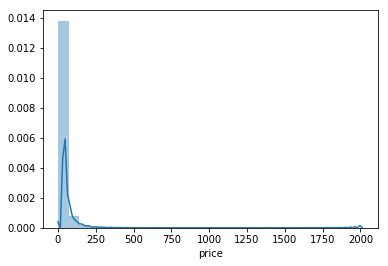

In [26]:
sns.distplot(final['price'],bins=30)

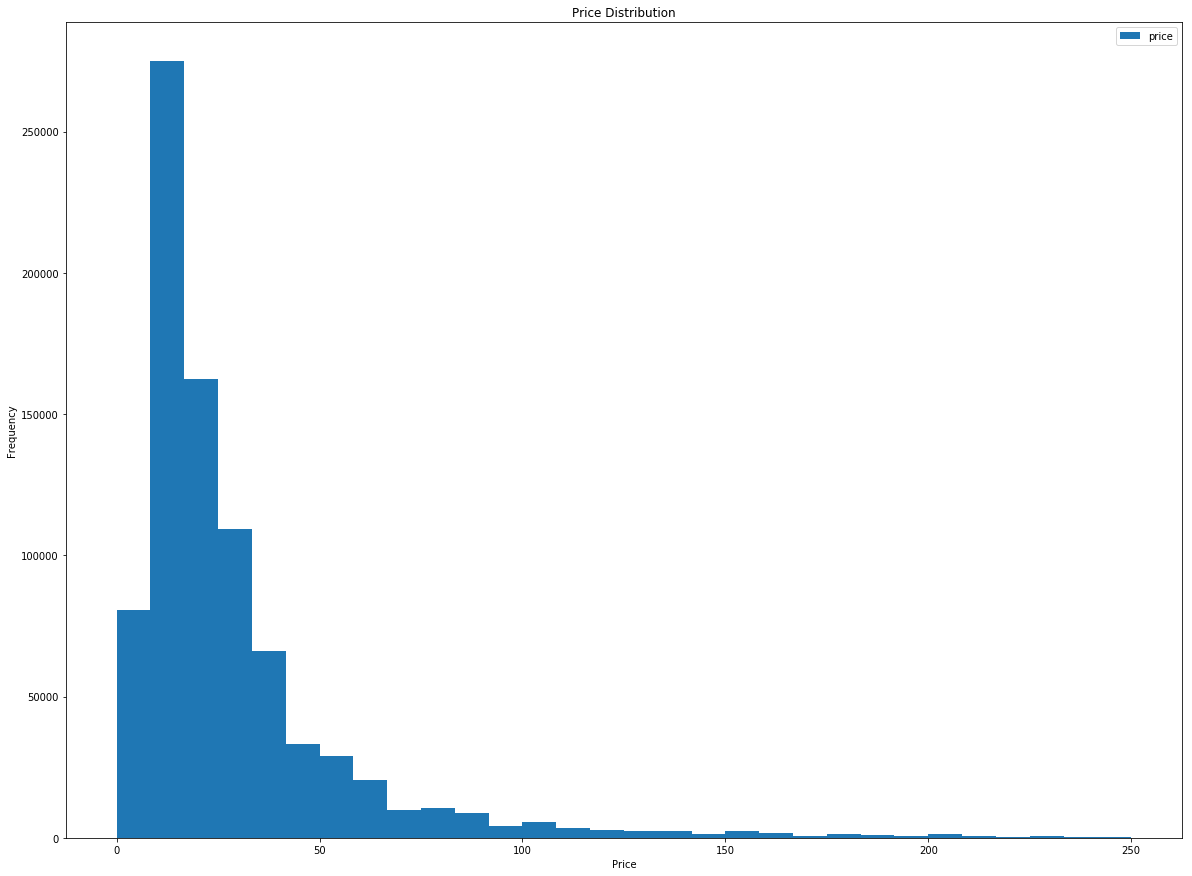

In [27]:
plt.figure(figsize=(20, 15))
plt.hist(final['price'], bins=30, range=[0,250], label='price')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

75% of the products in our data are priced under $34.00.

### Categories

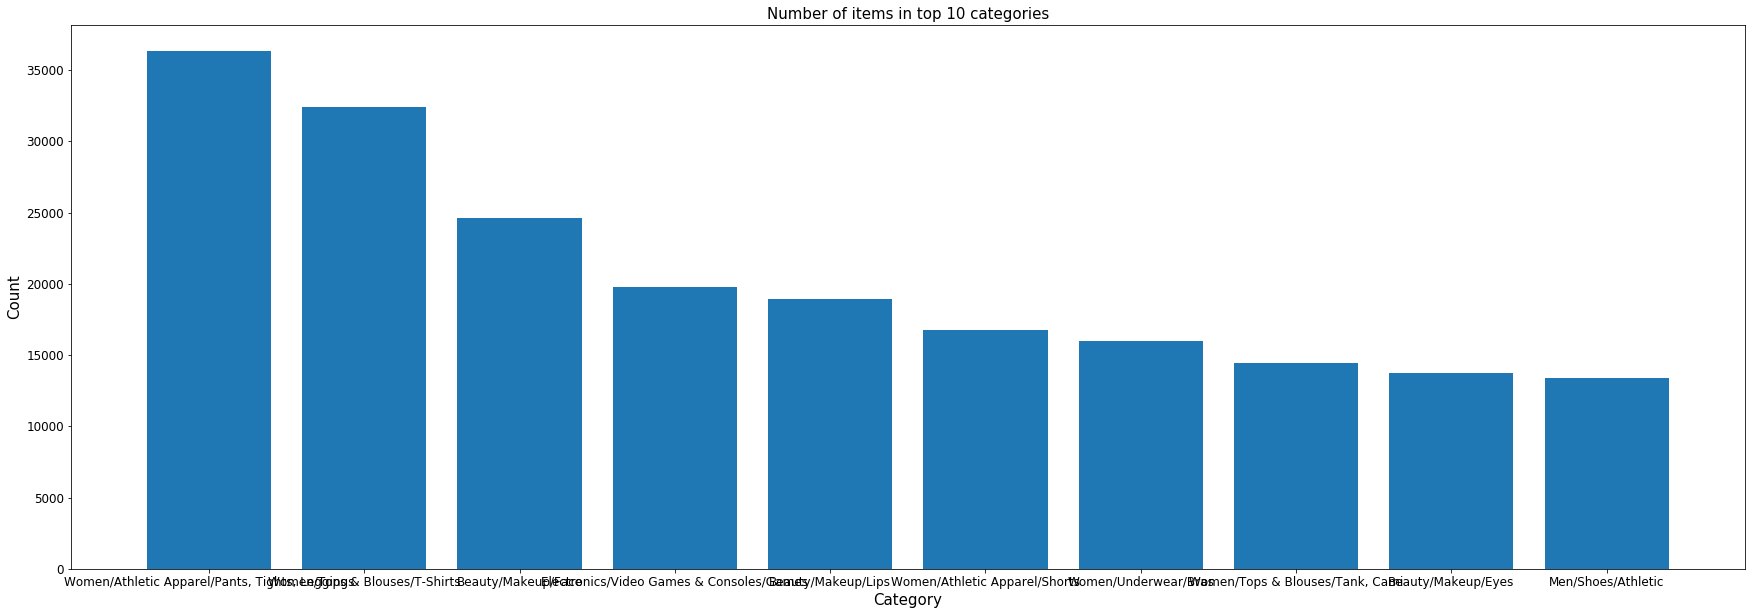

In [28]:
x = final['category_name'].value_counts().index.values.astype('str')[:10]
y = final['category_name'].value_counts().values[:10]
objects = set(final['category_name'])

plt.figure(figsize=(30,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.title('Number of items in top 10 categories', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
 
plt.show()

In [29]:
unique_categories = final['category_name'].value_counts()
print('Number of Unique categories :', unique_categories.shape[0])

Number of Unique categories : 914


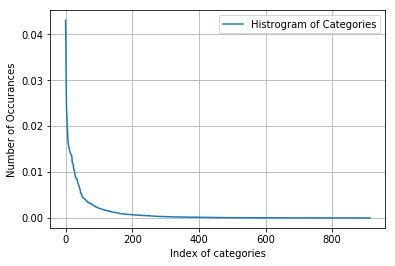

In [30]:
s = sum(unique_categories.values);
h = unique_categories.values/s;
plt.plot(h, label="Histrogram of Categories")
plt.xlabel('Index of categories')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

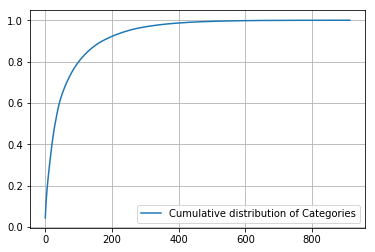

In [31]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Categories')
plt.grid()
plt.legend()
plt.show()

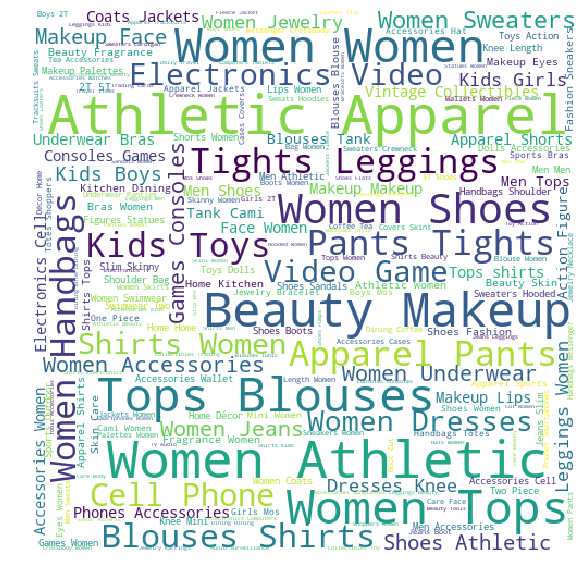

In [32]:
from wordcloud import WordCloud
import os

wordcloud = WordCloud(background_color="white", margin=0, width = 500, height = 500).generate(" ".join(final.category_name.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

1. Categories related to women have more number of products than any other categories.
2. 95% of the products are under the top 300 categories

### Brand

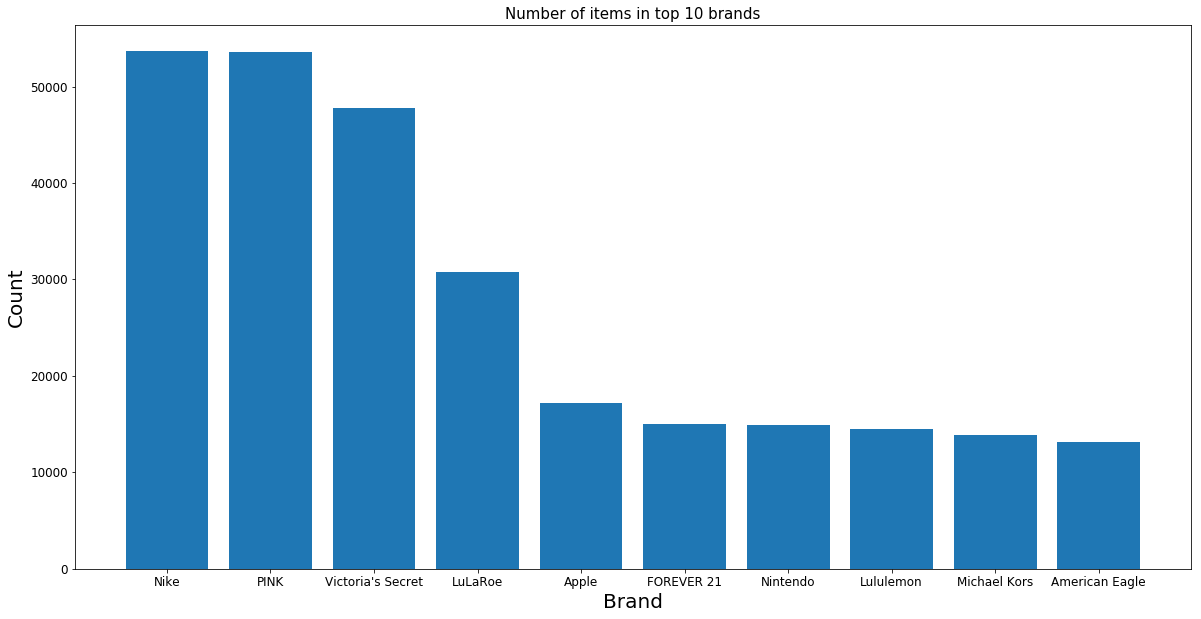

In [33]:
x = final['brand_name'].value_counts().index.values.astype('str')[:10]
y = final['brand_name'].value_counts().values[:10]
objects = set(final['brand_name'])

plt.figure(figsize=(20,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count', fontsize=20)
plt.xlabel('Brand', fontsize=20)
plt.title('Number of items in top 10 brands', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [34]:
unique_brands = final['brand_name'].value_counts()
print('Number of Unique Brands :', unique_brands.shape[0])

Number of Unique Brands : 4786


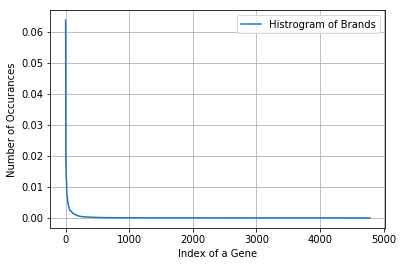

In [35]:
s = sum(unique_brands.values);
h = unique_brands.values/s;
plt.plot(h, label="Histrogram of Brands")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

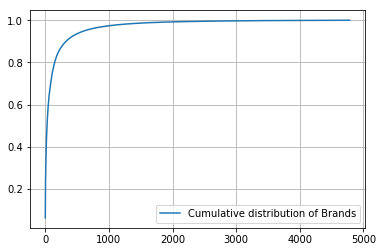

In [36]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Brands')
plt.grid()
plt.legend()
plt.show()

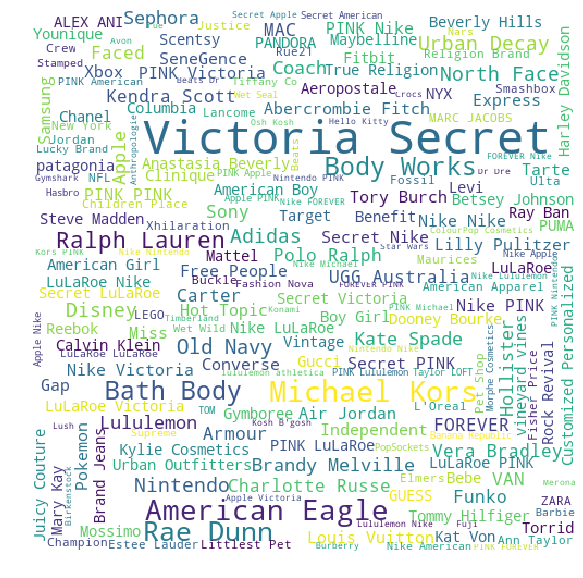

In [37]:
wordcloud = WordCloud(background_color="white", margin=0, width = 500, height = 500).generate(" ".join(final.brand_name.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

97% of the products comes under the top 1000 brands

### Item Condition

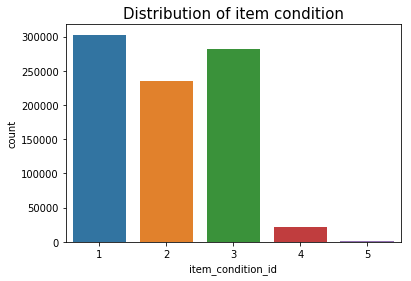

In [38]:
fig, ax = plt.subplots()
plt.title('Distribution of item condition', fontsize=15)
sns.countplot(final.item_condition_id)
ax.set_ylabel('count')

plt.show()

condition of the items 1 and 3 seems to be the mojority class where as 4 and 5 are the minor classes.

### Shipping

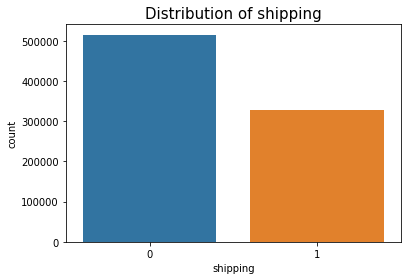

In [39]:
fig, ax = plt.subplots()
plt.title('Distribution of shipping', fontsize=15)
sns.countplot(final.shipping)
ax.set_ylabel('count')

plt.show()

Over 500k products doesn't have the shipping charges